# Import Dependencies

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import PIL

In [ ]:
plants = pd.read_csv("/content/drive/MyDrive/plant_pathology_data/train.csv")


In [ ]:
plants['labels'] = plants['labels'].apply(lambda s: [l for l in str(s).split(' ')])
plants.head()

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(plants['image'], plants['labels'], test_size=0.2, random_state=44)
print("Number of plants for training: ", len(X_train))
print("Number of plants for validation: ", len(X_val))

Number of plants for training:  14905
Number of plants for validation:  3727


In [ ]:
X_train = [os.path.join('/content/drive/MyDrive/plant_pathology_data/resized_train_images', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/MyDrive/plant_pathology_data/resized_train_images', str(f)) for f in X_val]
X_train[:3]

['/content/drive/MyDrive/plant_pathology_data/resized_train_images/af553a0d837a954a.jpg',
 '/content/drive/MyDrive/plant_pathology_data/resized_train_images/aae0c5cef43a4e07.jpg',
 '/content/drive/MyDrive/plant_pathology_data/resized_train_images/b63e966f4a0ae28a.jpg']

In [ ]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['rust'], ['frog_eye_leaf_spot'], ['frog_eye_leaf_spot', 'complex']]

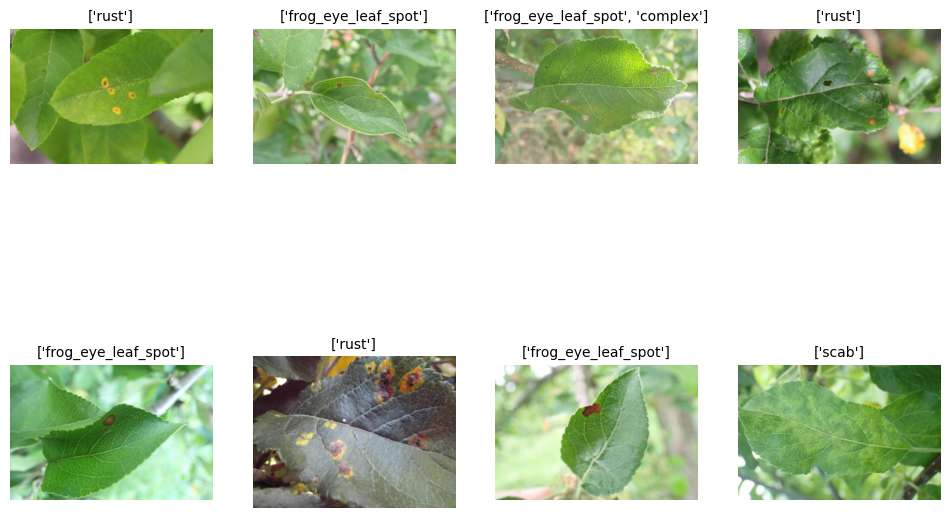

In [ ]:
import matplotlib.style as style
from PIL import Image
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. complex
1. frog_eye_leaf_spot
2. healthy
3. powdery_mildew
4. rust
5. scab


In [ ]:
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [ ]:
for i in range(3):
    print(X_train[i], y_train_bin[i])

/content/drive/MyDrive/plant_pathology_data/resized_train_images/af553a0d837a954a.jpg [0 0 0 0 1 0]
/content/drive/MyDrive/plant_pathology_data/resized_train_images/aae0c5cef43a4e07.jpg [0 1 0 0 0 0]
/content/drive/MyDrive/plant_pathology_data/resized_train_images/b63e966f4a0ae28a.jpg [1 1 0 0 0 0]


In [ ]:
IMG_SIZE = 160 
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [ ]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [ ]:
BATCH_SIZE = 64 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [ ]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [ ]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training = False)

In [ ]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (64, 160, 160, 3)
Shape of labels array: (64, 6)


In [ ]:
import tensorflow_hub as hub
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_160/feature_vector/5"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
feature_extractor_layer.trainable = False

# CNN Model

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 6)                 6150      
                                                                 
Total params: 3,575,878
Trainable params: 1,317,894
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
EPOCHS = 8

# Train the Model

In [ ]:
model_bce = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.metrics.binary_crossentropy)
    
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=val_ds)

Epoch 1/8
233/233 [==============================] - 2139s 9s/step - loss: 0.3467 - val_loss: 0.2761
Epoch 2/8
233/233 [==============================] - 17s 75ms/step - loss: 0.2537 - val_loss: 0.2506
Epoch 3/8
233/233 [==============================] - 20s 87ms/step - loss: 0.2343 - val_loss: 0.2380
Epoch 4/8
233/233 [==============================] - 20s 87ms/step - loss: 0.2236 - val_loss: 0.2317
Epoch 5/8
233/233 [==============================] - 20s 87ms/step - loss: 0.2166 - val_loss: 0.2311
Epoch 6/8
233/233 [==============================] - 17s 74ms/step - loss: 0.2110 - val_loss: 0.2244
Epoch 7/8
233/233 [==============================] - 18s 79ms/step - loss: 0.2065 - val_loss: 0.2217
Epoch 8/8
233/233 [==============================] - 17s 75ms/step - loss: 0.2030 - val_loss: 0.2215


# Making Predictions

In [ ]:
from keras.preprocessing import image

def show_prediction(img_name, plants_df, model):
    
    # Get movie info
    image_name = plants.loc[plants['image']==img_name].iloc[0]
    plant_label = plants.loc[plants['image']==img_name]['labels'].iloc[0]
    img_path = os.path.join('/content/drive/MyDrive/plant_pathology_data/resized_train_images/', str(img_name))

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nLabel\n{}\n\nPrediction\n{}\n'.format(img_name, plant_label, list(prediction)), fontsize=9)
    plt.show()

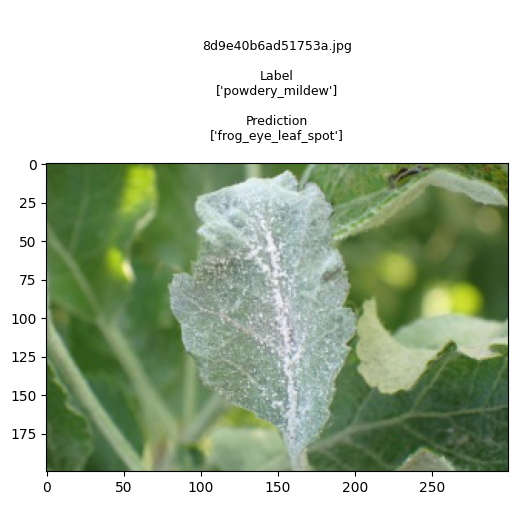

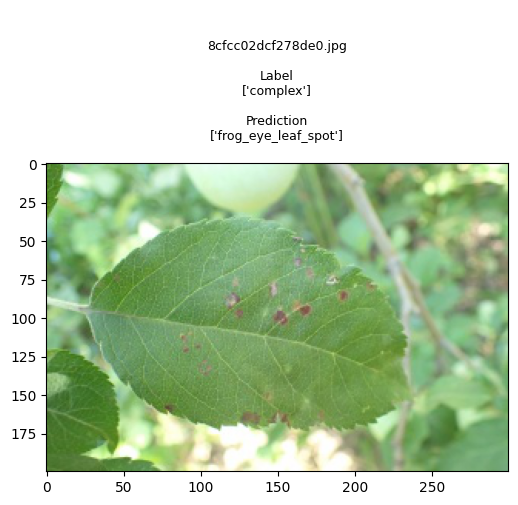

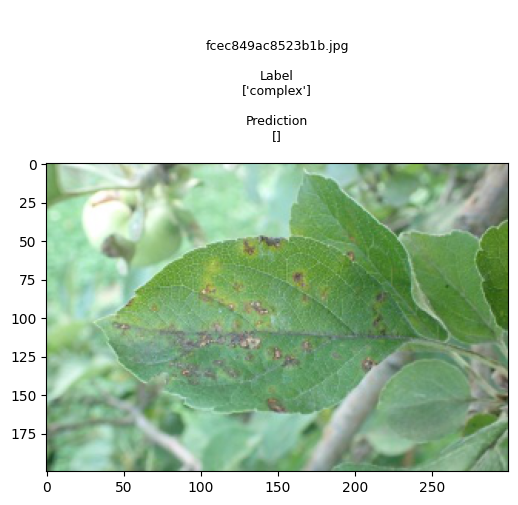

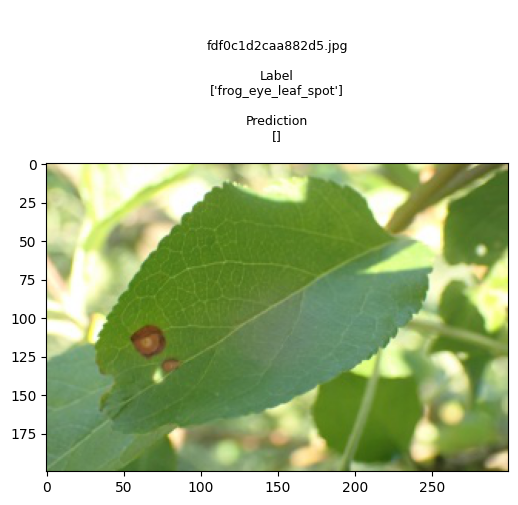

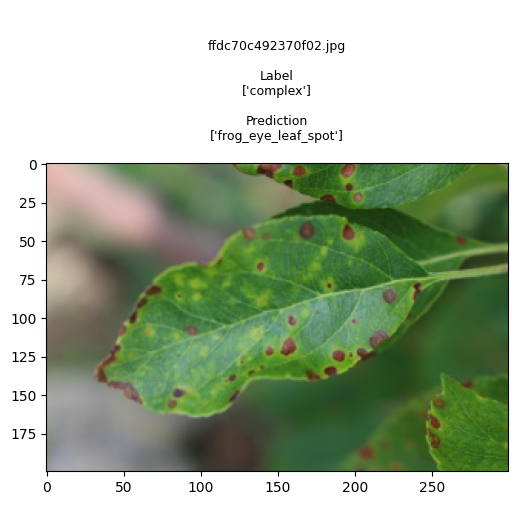

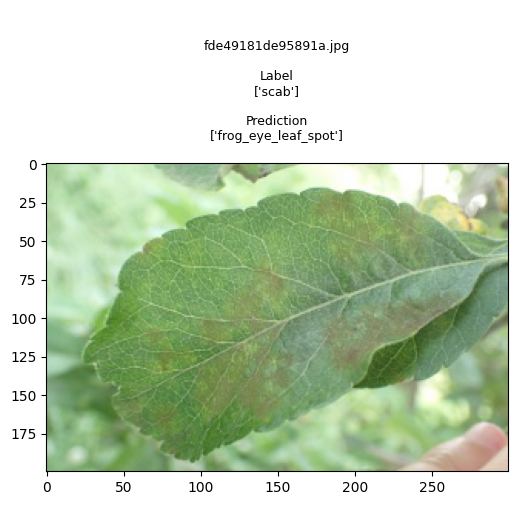

In [ ]:
image_list = ["8d9e40b6ad51753a.jpg",
          "8cfcc02dcf278de0.jpg",
          "fcec849ac8523b1b.jpg",
          "fdf0c1d2caa882d5.jpg",
          "ffdc70c492370f02.jpg",
          "fde49181de95891a.jpg"]

for i in image_list:
    show_prediction(i, plants, model)

In [ ]:
print(mlb.classes_)
type(mlb.classes_)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']


numpy.ndarray

In [ ]:
classes = np.array(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab'])
print(classes)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']


# Saving the Model

In [ ]:
tf.keras.models.save_model(model_bce,'model.hdf5')